In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import ElasticNet
from sklearn.metrics import roc_curve
from sklearn import metrics
#from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from scipy import stats
from matplotlib import pyplot
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import shap
import optuna
import random
from scipy.special import expit
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn

print(sklearn.__version__)
print(optuna.__version__)

1.0
2.10.1


In [46]:
! cp ../input_files/training_data_smoothedMHfeatures.txt . 
! cp ../input_files/holdout_final.tsv .

In [59]:
# Readng in both training and hold out test set 
df = pd.read_csv("training_val_data_smoothedMHfeatures.txt", 
                 sep="\t").set_index("sample")

holdout_df = pd.read_csv("holdout_final.tsv", sep="\t").set_index("sample").drop(columns=["perc"])



In [52]:
# Stratifying into training and validation dataset
random.seed(1)
X_train, X_val , train_label, val_label = train_test_split(df.drop(columns=['Label']),
                                                                 df[["Label"]], test_size=0.2,
                                                                 stratify=df["Label"],
                                                                 random_state=1)

# Filling with high value (if no variants, we assume that we have no cont from those sites)
X_train = X_train.fillna(0.98)
X_val = X_val.fillna(0.98)

# Scaling data with Minmax and creating DF from training and validation again 
scaler = MinMaxScaler()
scaler = scaler.fit(X_train)
new_train = scaler.transform(X_train)

new_train = pd.DataFrame(new_train)
new_train.columns = X_train.columns
new_train.index = X_train.index
plot_train_df = new_train


new_val = scaler.transform(X_val) #predicting test based on fitted training  
new_val = pd.DataFrame(new_val)
new_val.columns = X_val.columns
new_val.index = X_val.index




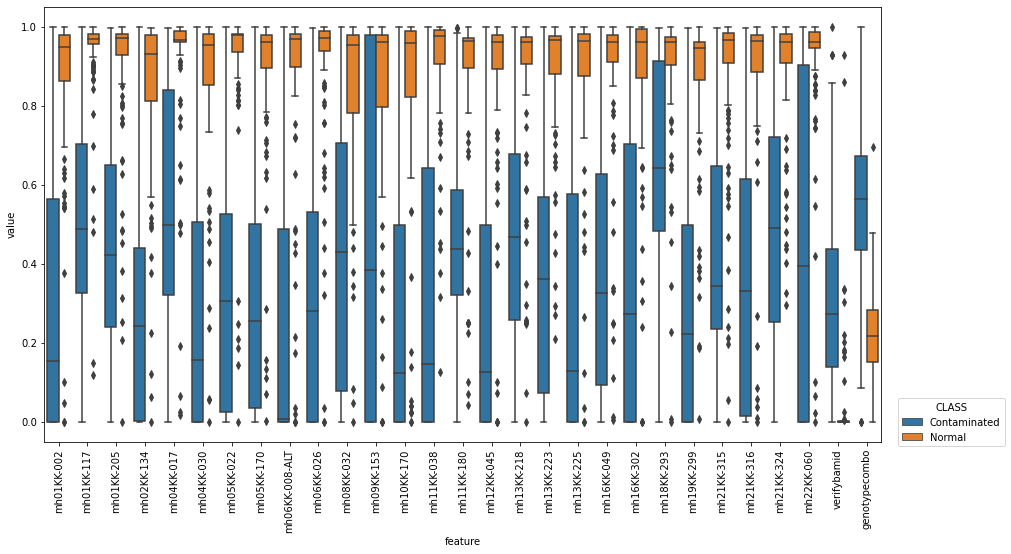

In [67]:
plt.figure(figsize=(15,8))
plot_features_df = pd.read_csv("plot_features.csv")
sns.boxplot(data=plot_features_df,x="feature",y="value",hue="label")
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.02, 0.1), borderaxespad=0,loc="upper left",title='CLASS')
plt.show() 
#plt.savefig("feature_distribution.png",dpi=300)

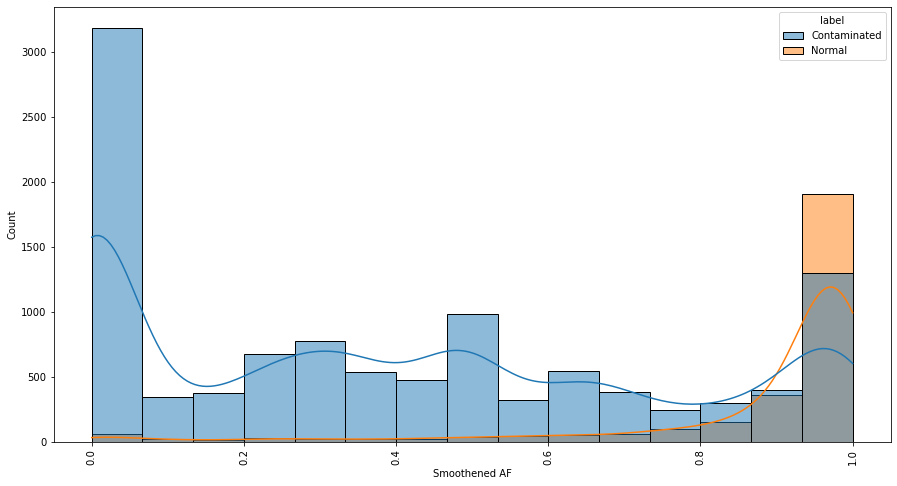

<Figure size 432x288 with 0 Axes>

In [68]:
plt.figure(figsize=(15,8))
plot_smooth_df = pd.read_csv("smoothened_af.csv")
sns.histplot(data=plot_smooth_df,x="value",  hue="label", kde=True)
plt.xticks(rotation=90)
plt.xlabel("Smoothened AF")
#plt.legend(bbox_to_anchor=(1.02, 0.1), borderaxespad=0,loc="upper left",title='CLASS')
plt.show()
plt.clf()
#plt.savefig("feature_distribution.png",dpi=300)

In [69]:
# Creating a model from training dataset 
random.seed(1)
model = LogisticRegression(penalty='l2', C=0.03059336595800154,  solver='saga')

# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, new_train, train_label.values.ravel(),scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
Standard_error = stats.sem(n_scores,axis=None,ddof=0)
print('10 fold AUROC: %.4f (%.4f)' % (mean(n_scores), Standard_error))

# Fitting a model with training dataset 
model.fit(new_train,train_label.values.ravel())
y_pred = model.predict(new_train)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(train_label.values.ravel(), predictions)
print('Train accuracy: ' + str(accuracy))


# Fitting model to validation dataset and predicting accuracy 
y_pred = model.predict(new_val)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(val_label.values.ravel(), predictions)
prediction_probabilities = model.predict_proba(new_val)
validation_auc = roc_auc_score(val_label, prediction_probabilities[:, 1])
print('Validation AUROC: ' + str(validation_auc))
print('Validation accuracy: ' + str(accuracy))

# Printing confusion matrix 
cm = confusion_matrix(val_label.values.ravel(), y_pred)
print(cm)
print("\nThe model found",cm[0][1],"false positives","and",cm[1][0],"false negatives")


## Error analysis
sample = new_test.reset_index()["sample"]
prediction_probabilities = model.predict_proba(new_val)

print("\nList of FP and FN samples -- ")
for i in range (0,len(sample)):
    MatchFlag = "TRUE"
    if int(predictions[i])==1 and int(val_label["Label"].values.ravel()[i])==0:
        print("This sample-",sample[i],"is a FP with prob prediction of",prediction_probabilities[i][0],"that it is contaminated")
    elif int(predictions[i])==0 and int(val_label["Label"].values.ravel()[i])==1:
        print("This sample-",sample[i],"is a FN with prob prediction of",prediction_probabilities[i][1],"that it is non-contaminated")



10 fold AUROC: 0.9692 (0.0051)
Train accuracy: 0.9548133595284872
Validation AUROC: 0.9893656032269893
Validation accuracy: 0.96875
[[25  2]
 [ 2 99]]

The model found 2 false positives and 2 false negatives

List of FP and FN samples -- 
This sample- HQ3626-R04_92_NGS41-HD832-S1_8 is a FN with prob prediction of 0.4952230444935878 that it is non-contaminated
This sample- Dev8-14 is a FP with prob prediction of 0.44353473303767676 that it is contaminated
This sample- PE9187-S1-R01_96_FFPE9187-S1-200_4 is a FN with prob prediction of 0.33780329235751166 that it is non-contaminated
This sample- PE9768-S1 is a FP with prob prediction of 0.09104510972539304 that it is contaminated


In [70]:
# holdout test set validation 
holdout_label = holdout_df.iloc[:,-1]
holdout_df_final = holdout_df[new_train.columns].fillna(0.98)

scaler = MinMaxScaler()
#scaler = RobustScaler()
scaler = scaler.fit(X_train)
new_holdout = scaler.transform(holdout_df_final)
new_holdout = pd.DataFrame(new_holdout)
new_holdout.columns = holdout_df_final.columns
new_holdout.index = holdout_df_final.index

# Error analysis 
y_pred = model.predict(new_holdout)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(holdout_label.values.ravel(), predictions)
print('Hold-out test accuracy: ' + str(accuracy))
prediction_probabilities = model.predict_proba(new_holdout)
holdout_auc = roc_auc_score(holdout_label, prediction_probabilities[:, 1])
print('Holdout AUROC: ' + str(holdout_auc))
holdout_recall = recall_score(holdout_label, y_pred)
print('Holdout recall: ' + str(holdout_recall))
holdout_prec = precision_score(holdout_label, y_pred)
print('Holdout precision: ' + str(holdout_prec))
cm = confusion_matrix(holdout_label.values.ravel(), y_pred)
print(cm)
print("\nThe model found",cm[0][1],"false positives","and",cm[1][0],"false negatives")        

Hold-out test accuracy: 0.9428571428571428
Holdout AUROC: 0.9950000000000001
Holdout recall: 0.93
Holdout precision: 0.9489795918367347
[[105   5]
 [  7  93]]

The model found 5 false positives and 7 false negatives


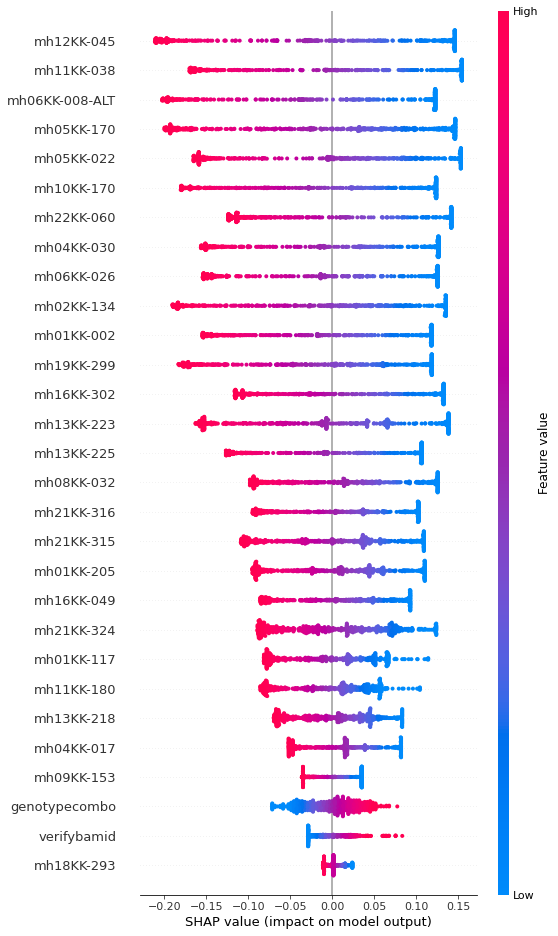

<Figure size 432x288 with 0 Axes>

In [71]:
explainer = shap.LinearExplainer(model, new_train)
shap_values = explainer.shap_values(new_train)
shap.summary_plot(shap_values, new_train, max_display=30, show=False)
plt.show()
plt.clf()
#plt.savefig("feature_summary_plot_shap.png",dpi=300)

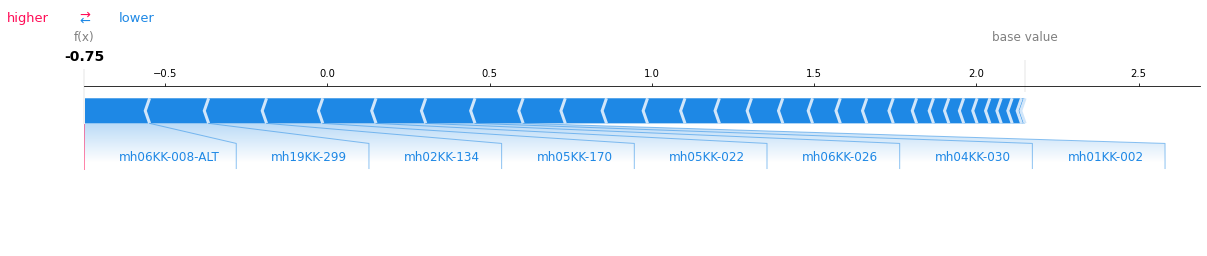

In [73]:
shap.initjs()
shap_vals = explainer.shap_values(new_holdout.loc['NGS41-183'])
shap.force_plot(explainer.expected_value,
                   explainer.shap_values(new_holdout.loc['NGS41-183']),
                   feature_names=np.asarray(new_holdout.columns), show=False, matplotlib=True
                   ).savefig("explanation_fig_3a.png",dpi=300)

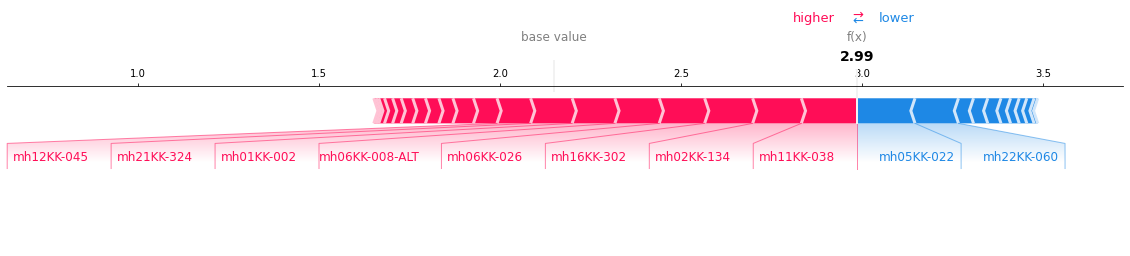

In [74]:
shap.initjs()
shap_vals = explainer.shap_values(new_holdout.loc['NGS41-MH25-P25'])
shap.force_plot(explainer.expected_value,
                   explainer.shap_values(new_holdout.loc['NGS41-MH25-P25']),
                   feature_names=np.asarray(new_val.columns), show=False, matplotlib=True
                   ).savefig("explanation_fig_3b.png",dpi=300)

In [75]:
## Error analysis
sample = holdout_df_final.reset_index()["sample"]
prediction_probabilities = model.predict_proba(new_holdout)
# Print samples with their prediction_prob
for i in range (0,len(sample)):
    MatchFlag = "TRUE"
    if int(predictions[i]) != int(holdout_label.values.ravel()[i]):
        MatchFlag = "FALSE"
    #print(sample[i],int(val_label.values.ravel()[i]),prediction_probabilities[i][1], prediction_probabilities[i][0],predictions[i], 0,MatchFlag)
    if MatchFlag == "FALSE":
        print(sample[i], prediction_probabilities[i])
        

Chimerism5 [0.51557146 0.48442854]
Labmix97-2-1 [0.50622226 0.49377774]
Labmix98-2 [0.60421028 0.39578972]
Labmix99-1 [0.57252765 0.42747235]
NGS41-017 [0.49284862 0.50715138]
NGS41-027 [0.48616531 0.51383469]
NGS41-038 [0.49059654 0.50940346]
NGS41-090-FFPE [0.42139636 0.57860364]
NGS41-188-R01 [0.44011751 0.55988249]
NGS41-MH02-P01 [0.5247791 0.4752209]
NGS41-MH05-P03 [0.57305773 0.42694227]
NGS41-MH15-P07 [0.51415042 0.48584958]


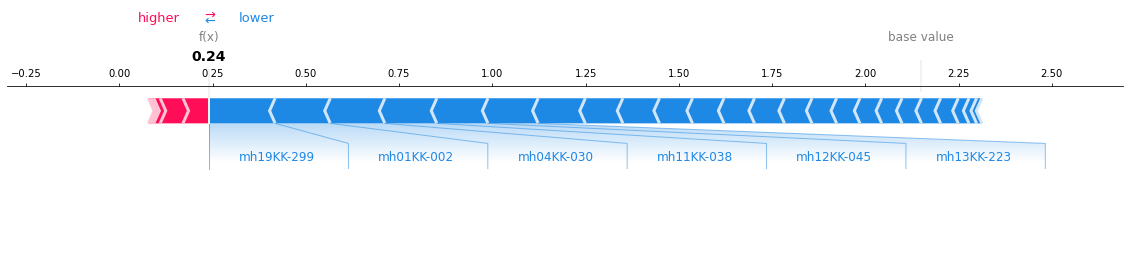

In [77]:
shap.initjs()
shap_vals = explainer.shap_values(new_holdout.loc['NGS41-188-R01'])
shap.force_plot(explainer.expected_value,
                   explainer.shap_values(new_holdout.loc['NGS41-188-R01']),
                   feature_names=np.asarray(new_holdout.columns), show=False, matplotlib=True
                   ).savefig("error_analysis/NGS41-188-R01.png",dpi=300)

<Figure size 432x288 with 0 Axes>

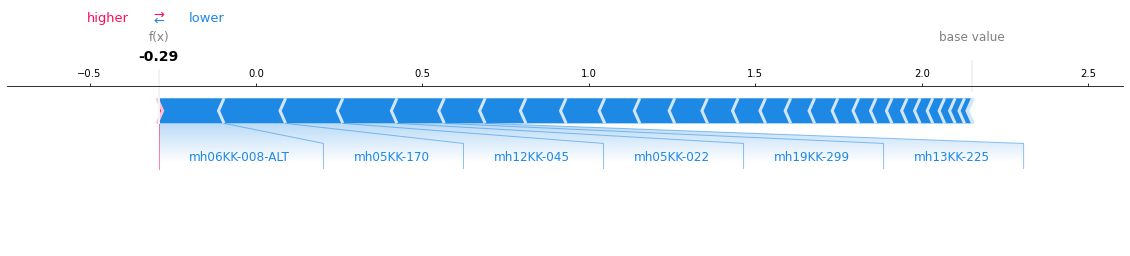

In [78]:
#Labmix70-30
plt.clf()
shap.initjs()
shap_vals = explainer.shap_values(new_holdout.loc["Labmix99-1"])
shap.force_plot(explainer.expected_value,
                   explainer.shap_values(new_holdout.loc["Labmix99-1"]),
                   feature_names=np.asarray(new_holdout.columns), show=False, matplotlib=True
                   ).savefig("error_analysis/Labmix99-1.png",dpi=300)

<Figure size 432x288 with 0 Axes>

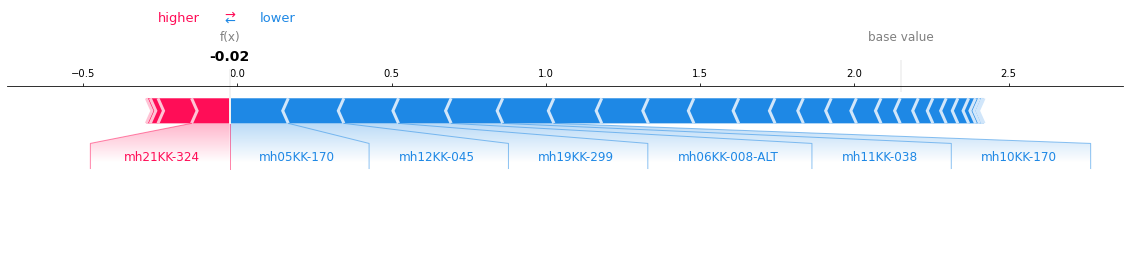

In [79]:
#Labmix97-2-1
plt.clf()
shap.initjs()
shap_vals = explainer.shap_values(new_holdout.loc['Labmix97-2-1'])
shap.force_plot(explainer.expected_value,
                   explainer.shap_values(new_holdout.loc['Labmix97-2-1']),
                   feature_names=np.asarray(new_holdout.columns), show=False, matplotlib=True
                   ).savefig("error_analysis/Labmix97-2-1.png",dpi=300)